### Vanden-Eijnden 

In [27]:
using PyPlot, StatsBase, Printf, DelimitedFiles, Combinatorics;
using Revise;
using MDToolbox;
PyPlot.plt.style.use("seaborn-colorblind");
ENV["COLUMNS"] = 110; #display width for MDToolbox

### Potential energy function its gradients

In [28]:
V(x; k=1.0) = sum(- (1.0 / 2.0) .* k .* x.^2 .+ (1.0 ./ 4.0) .* k .* x.^4)
V([0.0])

0.0

In [29]:
grad(x; k= 1.0) =  - k .* x .+ k .* x.^3

grad (generic function with 1 method)

In [30]:
ISgrad(x, beta_replica, beta_sigma; k=1.0) = (-k .* x .+ k .* x.^3) ./ beta_replica .* beta_sigma

ISgrad (generic function with 1 method)

In [31]:
proposal_fun(x) = x .+ (rand(Float64, size(x)) .* 2.0 .- 1.0);
proposal_fun([0.0])

1-element Array{Float64,1}:
 -0.5058014076096833

### Define functions for infinite swapping

あるi番目のレプリカのpdf
\begin{align}
{\rho}_i({\bf x_i}) =  e^{-V({\bf x_i})/T_i}
\end{align}

系全体のpdfをQ(x)とするとき
ある置換σのpdfは
\begin{align}
Q(\sigma ,X) =1/N! {\rho}_{\sigma(1)}({\bf x_1}),...,{\rho}_{\sigma(N)}({\bf x_N})
\end{align}

ある置換σでのポテンシャル
\begin{align}
V(X, \sigma) = -\beta^{-1}{\bf log}Q(\sigma,X)=\beta^{-1}\sum_{i=1}^{N}\beta_{\sigma(i)}V(x_i)+const
\end{align}

運動方程式
\begin{align}
ma_j=-\beta^{-1}\beta_{\sigma(j)}\nabla V(x_j)-\gamma mv+\sqrt{2\gamma m \beta^{-1}} 
\end{align}

次のステップの座標計算
\begin{align}
x_{next}=x_{current} -{\Delta t} \nabla{V(x_{current})} + \sqrt{2 \Delta t\beta^{-1}}(rand)
\end{align}


ISREMDの運動方程式
\begin{align}
ma_j=-\beta^{-1}\sum_{\sigma} \beta_{\sigma(j)}\omega_x(\sigma)\nabla V(x_j)-\gamma mv+ \sqrt{2\gamma m \beta^{-1}} 
\end{align}

ISREMDの
次のステップの座標計算
\begin{align}
x_{next}=x_{current} -{\Delta t}\nabla{V(x_{current})}\beta^{-1}_{replica}\sum_{\sigma}\beta _{\sigma(replica)} \omega_X(\sigma) + \sqrt{2 \Delta t\beta^{-1}}(rand)
\end{align}


各置換の重み

\begin{align}
\omega_X({\sigma}):= \frac{   Q(\sigma,X)}{ \sum_{{\sigma}'}Q({\sigma}',X)}
\end{align}

\begin{align}
<A>_j=\int A(x)\rho_j(x)dx
=\int \sum_{j=1}^N A(x_i)\sum_{\sigma}1_{j=\sigma(j)}\omega_x(\sigma)
    \end{align}

##温度Tにおけるxの分布は、以下のπに比例する

\begin{align}
\pi({\bf x},T) = e^{-V({\bf x})/T}
\end{align}

In [32]:
rho(x, T) = exp.(-V(x) ./ T)

rho (generic function with 1 method)

In [33]:
function calc_omega!(omega, x, T, perm)
    nreplica = length(x)   
    nperm=length(perm)
    qu = ones(Float64,nperm)
    qu_sum = 0.0
    for n = 1:nperm
        for i = 1:nreplica
            qu[n] *= rho(x[i], T[perm[n][i]])
        end
        qu[n] = 1/nperm * qu[n]
        qu_sum += qu[n]
    end
    for n = 1:nperm
        omega[n] = qu[n] / qu_sum
    end
end

calc_omega! (generic function with 1 method)

In [34]:
function calc_betasigma!(beta_sigma,beta_replica,perm,omega)
    beta_sigma .= 0.0
    nreplica=length(beta_replica)
    nperm=length(perm)
    for i=1:nreplica
        for n=1:nperm
            beta_sigma[i] += beta_replica[perm[n][i]] * omega[n]
        end
    end
end

calc_betasigma! (generic function with 1 method)

In [35]:
function flush_weight(io::IOStream, m, omega, perm)
    nperm = length(perm)
    nreplica = length(perm[1])
    weight = zeros(Float64, nreplica)
    
    for n = 1:nperm
        #id_replica = perm[n][m]
        id_replica = findall(iszero, perm[n] .- m)[1]
        weight[id_replica] += omega[n]
    end
    
    for i = 1:nreplica
        @printf(io, "%f ", weight[i])
    end
    @printf(io, "\n")
end

flush_weight (generic function with 1 method)

### Infinite swap MCMC

In [46]:
nreplica = 4
#temperature_replica = [0.01, 0.10, 0.30, 0.40];
temperature_replica = [0.01, 0.20, 0.50, 0.90];
#nstep = 20000;
nstep = 1000;

perm=collect(permutations(1:nreplica))
nperm=factorial(nreplica)
omega=zeros(Float64,nperm)
beta_sigma=zeros(Float64,nreplica)
beta_replica=1 ./ temperature_replica


x_replica = []
for i = 1:nreplica
    x = [0.0]
    push!(x_replica, x)
end

io_replica = []
for i = 1:nreplica
    filename = "IS_replica$(i).dat"
    io = open(filename, "w")
    push!(io_replica, io)
end



io_weight=[]
for m = 1:nreplica
    filename = "IS_weight$(m).dat"
    io = open(filename, "w")
    push!(io_weight, io)
end


In [47]:
   
icount = 0
for istep = 1:nstep
   
    for i = 1:nreplica
        calc_omega!(omega, x_replica, temperature_replica, perm)
        calc_betasigma!(beta_sigma, beta_replica, perm, omega)
    #    x_replica[i] = propagate_md(y -> grad(y,k=2.0), x_replica[i], temperature_replica[perm[n][i]], nstep=1, io=io_replica[i]);       
        x_replica[i] = propagate_md(y -> ISgrad(y,beta_replica[i],beta_sigma[i],k=1.0), x_replica[i], temperature_replica[i], nstep=1, io=io_replica[i]);       
    end
        for  m=1:nreplica
          flush_weight(io_weight[m], m, omega, perm)
        end
end

In [48]:
for i = 1:nreplica
    close(io_replica[i])
    close(io_weight[i])
end

### Trajectory analysis

In [49]:
traj_replica = []
temp_replica = []

for i = 1:nreplica
    filename = "IS_replica$(i).dat"
    data = readdlm(filename);
    push!(temp_replica, data[:, 1])
    push!(traj_replica, data[:, 2])
end

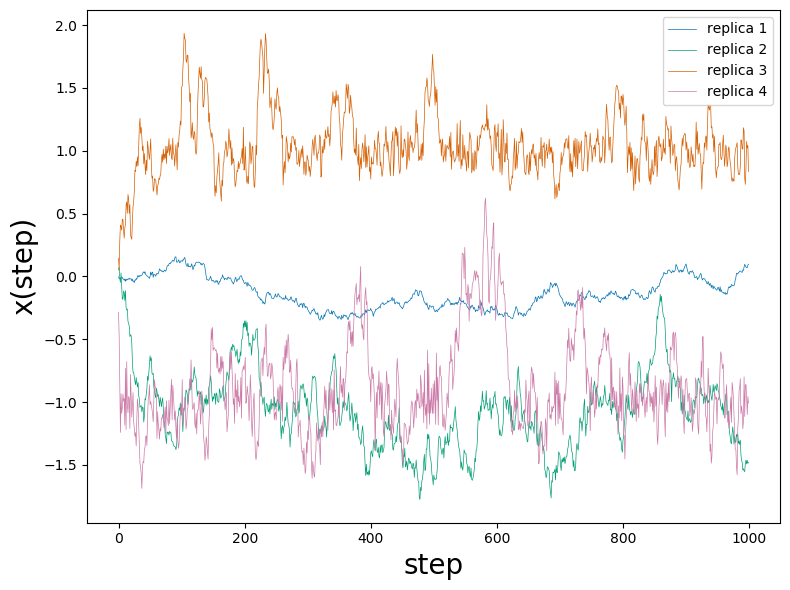

In [50]:
fig, ax = subplots(figsize=(8, 6))
for i = 1:nreplica
    ax.plot(traj_replica[i], linewidth=0.5)   
end
xlabel("step",fontsize=20)
ylabel("x(step)",fontsize=20)

ax.legend(["replica 1", "replica 2", "replica 3", "replica 4"])
tight_layout()

In [51]:
filename = "IS_weight1.dat"
weight_replica = readdlm(filename);

In [52]:
traj = traj_replica[1]
weight = weight_replica[:, 1]

for i = 2:nreplica
    traj = [traj; traj_replica[i]]
    weight = [weight; weight_replica[:, i]]
end
weight .= weight ./ sum(weight)

4000-element Array{Float64,1}:
 0.000170483001363864  
 2.0776000166208e-5    
 6.1000000488e-8       
 0.0                   
 0.0                   
 0.0                   
 0.0                   
 0.0                   
 0.0                   
 0.0                   
 0.0                   
 0.0                   
 0.0                   
 ⋮                     
 0.00041674700333397597
 0.00048006700384053605
 0.000351863002814904  
 0.00018148500145188   
 0.0005971050047768401 
 0.000626282005010256  
 0.000977139007817112  
 0.000493954003951632  
 0.0002488500019908    
 0.000472109003776872  
 0.000284876002279008  
 0.0008845190070761521 

In [53]:
x_grid = range(-1.3, 1.3, length=100);
pmf_theory = V.(x_grid) ./ temperature_replica[1]
pmf_theory .= pmf_theory .- minimum(pmf_theory);

In [54]:
#pmf_observed, _ = getpmf(traj_replica[1], weight=weight_replica[:, 1], grid_x = collect(x_grid), bandwidth=0.05);
pmf_observed, _ = getpmf(traj, weight=weight, grid_x = collect(x_grid), bandwidth=0.05);

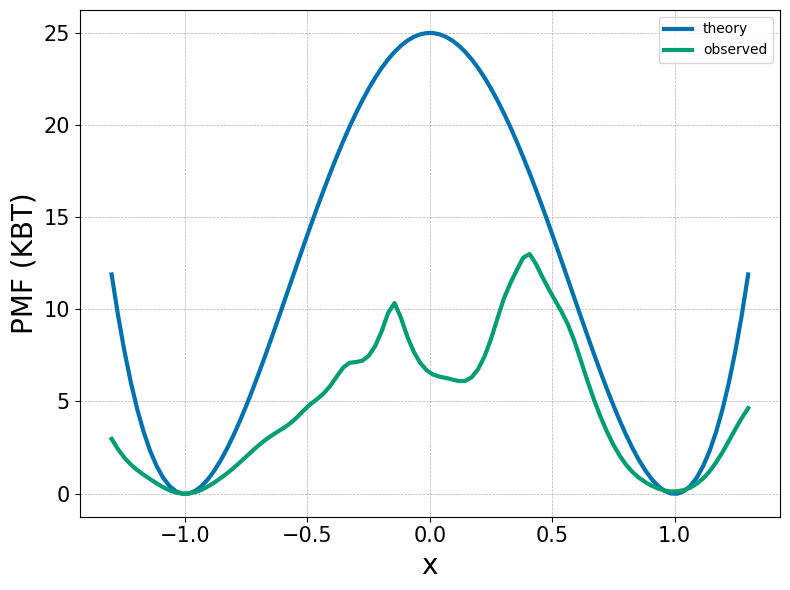

In [55]:
fig, ax = subplots(figsize=(8, 6))
ax.plot(x_grid, pmf_theory, linewidth=3)
xlabel("x",fontsize=20)
ylabel("PMF (KBT)",fontsize=20)

ax.plot(x_grid, pmf_observed, linewidth=3)

ax.legend(["theory", "observed"])

ax.xaxis.set_tick_params(which="major",labelsize=15)
ax.yaxis.set_tick_params(which="major",labelsize=15)
ax.grid(linestyle="--", linewidth=0.5)
tight_layout()
savefig("mcmc_infinite_swap.png", dpi=350)